# **INTRODUCTION**  
Welcome to Notebook 2 → *"Feature Matching for Image Matching Challenge 2025: ORB Approach"*

Firstly, apologies for the delay — I'm currently juggling exams and assignments! Also, a big thank you for all the upvotes and the kind comments on my first notebook — they truly motivated me to create this follow-up.

In this notebook, we’ll dive into the concept of **feature matching**, focusing specifically on the **Oriented FAST and Rotated BRIEF (ORB)** technique.

> **Note:** This notebook builds on the foundations laid in my first notebook. If you’re new to this challenge or the topic, I highly recommend checking that out first!

🔗 First Notebook: [Beginner-Friendly 1st Submission – EDA + ORB](https://www.kaggle.com/code/pragyatripathiii23/beginner-friendly-1st-submission-eda-orb)

In [1]:
#LOADING THE DATASET
import os 
dataset_path = "/kaggle/input/"
os.listdir(dataset_path)

['image-matching-challenge-2025']

In [2]:
import pandas as pd

# Loading train_labels.csv file
train_path = "../input/image-matching-challenge-2025/train" 
train_labels = pd.read_csv('/kaggle/input/image-matching-challenge-2025/train_labels.csv')

# Loading train_thresholds.csv file
train_thresholds_path = "../input/image-matching-challenge-2025/train_thresholds.csv"
train_thresholds = pd.read_csv(train_thresholds_path)

# **SO, WHAT IS FEATURE MATCHING?**

Let's begin by loading the same images we loaded in the previous notebook.

Both images are being purposefully loaded from the same scene using the training dataset(hence we already know they belong to the same scene, only the angles are different)

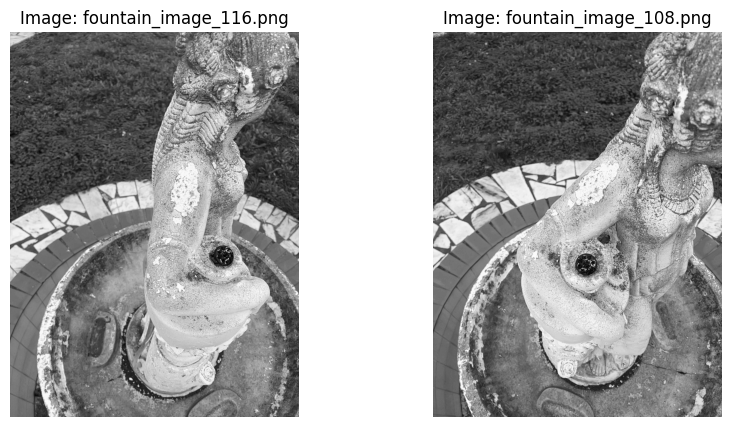

In [3]:
import cv2  # For reading and processing images
import matplotlib.pyplot as plt  # For visualizing images
import os  # For handling file paths

#selecting a specific scene from the training dataset
scene_name = "fountain"  #The idea is that all images with the scene "fountain" are of the same physical location (the same place, from different angles or times).
scene_images = train_labels[train_labels["scene"] == scene_name]["image"].values[:2]  # selecting the first two images from that scene

# Creating two side-by-side subplots to display both images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, img_name in enumerate(scene_images):
    img_path = os.path.join(train_path, train_labels[train_labels["scene"] == scene_name]["dataset"].values[0], img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Loaded image in grayscale (easier for feature matching) is standard for keypoint detection — no color info needed.
    #feature matching is almost always done in grayscale (non-color images).
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Image: {img_name}") ##show each image with its filename
    axes[i].axis("off")

plt.show()

In [4]:
#JUST GETTING PATH TO BOTH IMAGES SEPERATELY THROUGH THIS CODE FOR LATER ANALYSIS

# Get the dataset folder (since it's the same for all images in the scene)
dataset_folder = train_labels[train_labels["scene"] == scene_name]["dataset"].values[0]

# Construct full paths using the already selected `scene_images`
image_paths = [os.path.join(train_path, dataset_folder, img_name) for img_name in scene_images]

image1_path, image2_path = image_paths

#print("First image path:", image1_path)
#print("Second image path:", image2_path)

Let’s say I take a photo of the fountain from the front, and you take one from the side.
Even though the angle, lighting, and camera might be different, we both are capturing the same real-world structure.

No matter where we stand, we both still see:

* The rim of the fountain (where we sit)
* The base it stands on 
* The patterns or statues carved into it

These are consistent physical parts of the fountain — and in computer vision, we try to find and match them across images.
That’s exactly what features are in this context:

* Features are visually distinct, repeatable parts of an image that can be used to compare or match images of the same scene.

---

### What kinds of features do we detect?

Features are usually categorized into:

1. **Edges** — Lines or boundaries where there's a sharp change in brightness or color  
2. **Corners** — Points where two edges meet, like the tip of a building or the intersection of lines  
3. **Blobs** — Regions with similar texture surrounded by contrast (like a polka dot or a dark spot on a light background)

---

### Why are these features important?

Imagine trying to compare two images pixel by pixel — it would fail if there's even a small shift.

But by using features, we instead ask:

* “What meaningful parts exist in both images, regardless of the exact camera angle?”

These consistent parts give us a way to align, match, and understand images — even if they’re taken from different perspectives.

What are Keypoints?

* They are specific coordinates (x, y) in an image

* Tells you where a feature is

What are Descriptors?

* A vector that describes what’s around that point

* Tells you what that feature looks like

We detect keypoints (locations of features) and then use descriptors (vectors that describe what it looks like) to compare features.



So, in summary (just keep this in mind in case it's getting too much):-
* Feature- A distinct characterstick
* Keypoint- coordinate of a feature
* Descriptor- Vector describing a feature

# **ORB ALGORITHM**

ORB (Oriented FAST and Rotated BRIEF) is a feature detection and description algorithm used in computer vision. Its main job is to help a computer find key points in images — like corners or patterns — and then describe those points in a way that allows it to recognize the same points across different images, even if they're taken from different angles, distances, or under different lighting.

What ORB Does (in simple terms):

Think of it like this: ORB is like the brain’s visual memory. It looks for distinctive points in an image (such as sharp corners or textured areas), and then builds a tiny signature (descriptor) for each point — kind of like a unique fingerprint.

These descriptors are what make it possible to match points between two images — say, two photos of the same building, even if one is taken in the morning and the other in the evening.


**A Real-Life Analogy**

Imagine you're trying to recognize a familiar building — not just by its shape, but by the things around it. Maybe you remember it because:

* A tall tree stands just beside it.

* The sun always sets behind it when you walk by.

* There’s a coffee shop with a red sign on the corner.

Even if the building looks slightly different in a photo (maybe it's zoomed in, or taken from another angle), those surrounding clues help your brain say, “Oh yeah, I’ve seen this place before!”

In computer vision, ORB does something similar. It doesn’t just look at the building — it looks at the surrounding “features” and uses them as a guide to recognize the object. Those surrounding features are like the descriptors. When the algorithm finds enough matching features between two images, it can confidently say, “Yep, these images show the same thing.”

# **HOW ORB WORKS — STEP BY STEP**

## **1. Detect Keypoints using FAST**

ORB starts by finding keypoints in the image — these are places that stand out (like corners). 

It uses an algorithm called FAST (Features from Accelerated Segment Test), which is super fast and efficient.

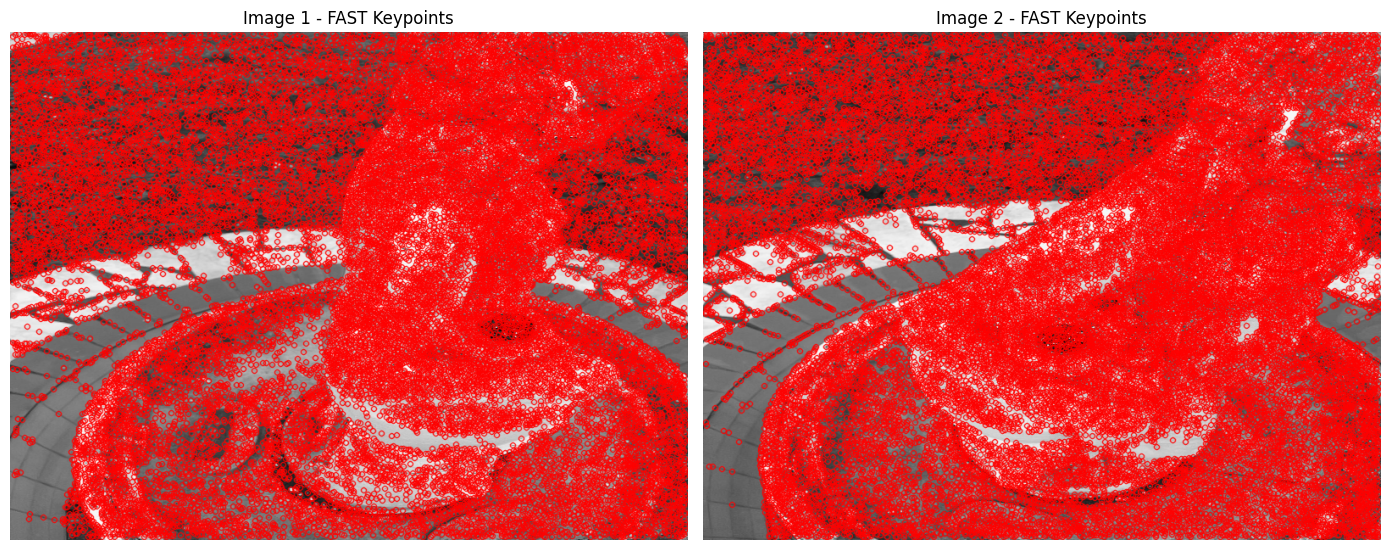

In [5]:
# Load and validate images
img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

# Optional: Resize large images to avoid long computation time
img1 = cv2.resize(img1, (800, 600))
img2 = cv2.resize(img2, (800, 600))

# FAST keypoint detection
fast = cv2.FastFeatureDetector_create()
keypoints1 = fast.detect(img1, None)
keypoints2 = fast.detect(img2, None)

# Draw keypoints
img1_with_kp = cv2.drawKeypoints(img1, keypoints1, None, color=(255, 0, 0))
img2_with_kp = cv2.drawKeypoints(img2, keypoints2, None, color=(255, 0, 0))

# Show the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Image 1 - FAST Keypoints")
plt.imshow(img1_with_kp, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Image 2 - FAST Keypoints")
plt.imshow(img2_with_kp, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()  

## **2. Rank Keypoints with Harris Score**

Once ORB finds many keypoints, it ranks them using a method called the **Harris corner measure** — this helps ORB pick the *most unique and stable* points to work with.

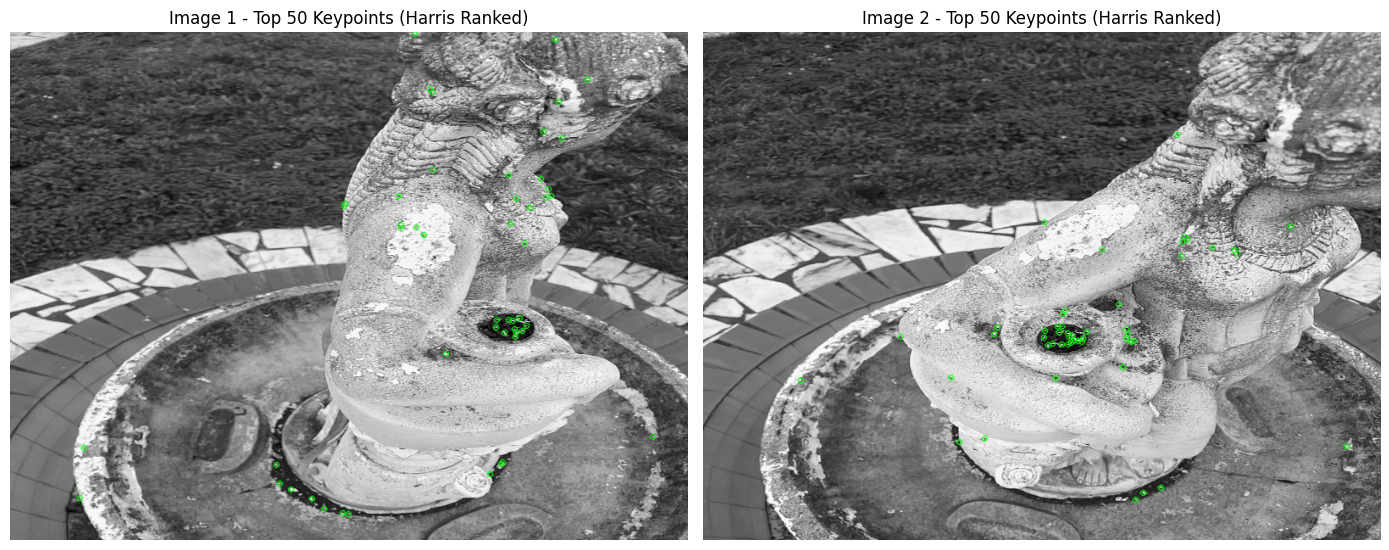

In [6]:
import numpy as np
def rank_keypoints_by_harris(img, keypoints, top_k=20):
    # Convert image to float32 for cornerHarris
    gray = np.float32(img)

    # Compute Harris corner response
    harris_response = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

    # Normalize the Harris response map (optional but useful for visualization or debugging)
    harris_response = cv2.normalize(harris_response, None, 0, 255, cv2.NORM_MINMAX)

    # Get Harris score for each keypoint
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if 0 <= y < harris_response.shape[0] and 0 <= x < harris_response.shape[1]:
            kp.response = harris_response[y, x]
        else:
            kp.response = 0  # Out of bounds safeguard

    # Sort by Harris response (descending) and return top K keypoints
    keypoints_sorted = sorted(keypoints, key=lambda x: x.response, reverse=True)
    return keypoints_sorted[:top_k]


# --- Rank and draw top 50 for both images ---
top_k = 50
top_kp1 = rank_keypoints_by_harris(img1, keypoints1, top_k)
top_kp2 = rank_keypoints_by_harris(img2, keypoints2, top_k)

# Draw top keypoints
img1_top = cv2.drawKeypoints(img1, top_kp1, None, color=(0, 255, 0))
img2_top = cv2.drawKeypoints(img2, top_kp2, None, color=(0, 255, 0))

# Plot top ranked keypoints
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Image 1 - Top 50 Keypoints (Harris Ranked)")
plt.imshow(img1_top, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Image 2 - Top 50 Keypoints (Harris Ranked)")
plt.imshow(img2_top, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

What we've done so far:

FAST gives us a bunch of keypoints — fast, but they’re not very "smart":

* They have no orientation (angle),

* And no scale (size),

* Just x, y positions where a corner was found.

Harris Score Ranking helps to prioritize the strongest keypoints from FAST, but:

* It still doesn't give us orientation.

* We still can't handle rotated images properly.


Imagine two photos of the same scene, but:

* One is upright,

* The other is rotated 45°.

If the keypoints don’t know their angle, then even if we match their location, we can’t match their appearance — because what used to be “up” is now sideways.




## **3. Orient the Keypoints**

ORB gives each keypoint an orientation, based on the surrounding pixels.

It rotates the descriptor (later step) to match that orientation, making it rotation invariant.

In simpler terms:

We're telling each keypoint, “Hey, remember which direction you're facing!”
So even when the scene is rotated, the computer still knows it's the same corner or pattern.

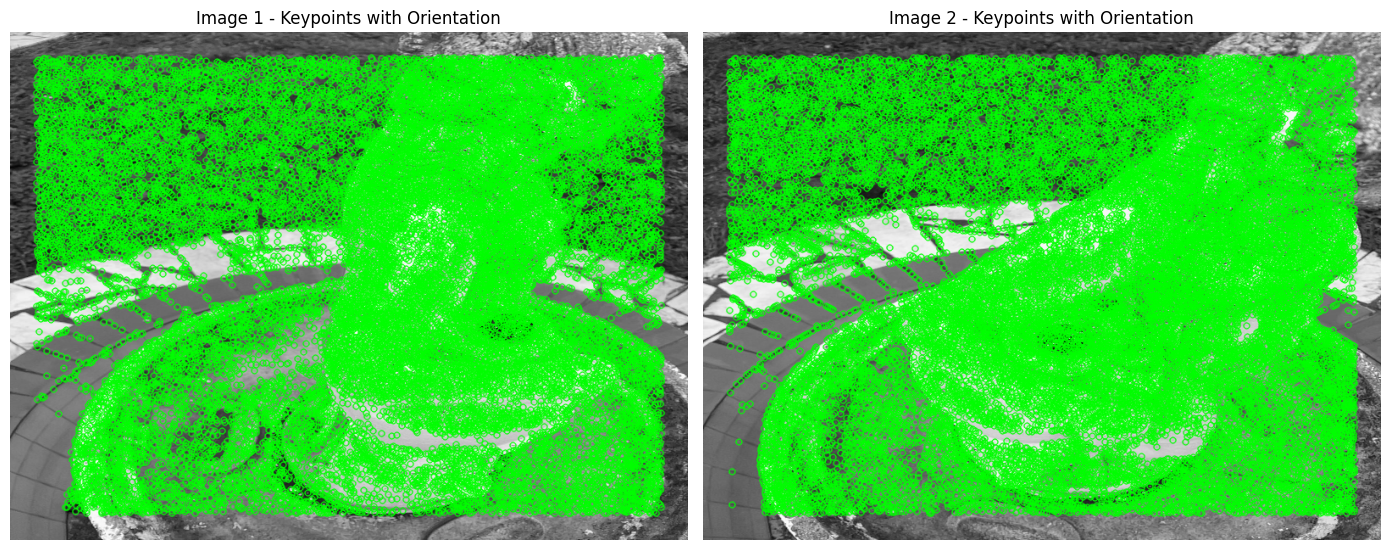

In [7]:
# Use ORB to compute orientation only (not descriptors)
orb = cv2.ORB_create()
keypoints1 = orb.compute(img1, keypoints1)[0]
keypoints2 = orb.compute(img2, keypoints2)[0]

# Draw keypoints with orientation arrows
img1_with_oriented_kp = cv2.drawKeypoints(img1, keypoints1, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
img2_with_oriented_kp = cv2.drawKeypoints(img2, keypoints2, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)


# Show side-by-side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Image 1 - Keypoints with Orientation")
plt.imshow(img1_with_oriented_kp, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Image 2 - Keypoints with Orientation")
plt.imshow(img2_with_oriented_kp, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


## **4. Compute descriptors using ORB (Rotated BRIEF)**

**What is BRIEF?**

BRIEF (Binary Robust Independent Elementary Features) is a way to describe the patch around each keypoint in a compact binary format — basically, a string of 0s and 1s.

It does this by comparing brightness between random pairs of pixels in a small patch around the keypoint.

For example, if one pixel is brighter than another, it assigns a 1, otherwise a 0. After many comparisons, we get a unique binary string like 101001....

* This string becomes the descriptor for that keypoint — a short fingerprint that can be compared with others using Hamming distance.



**But BRIEF Has a Problem: It’s Not Rotation-Invariant**

Let’s say an object is upright in one image and tilted in another. BRIEF might give very different descriptors for the same keypoint just because of the rotation.

So if we want reliable matching between images that might be taken from different angles..



**ORB Solves This by Rotating the BRIEF**

ORB improves BRIEF by aligning the patch based on the keypoint’s orientation (which was calculated in the previous step).

It rotates the patch around each keypoint to a standard direction.

Then it applies BRIEF on this aligned patch.

This makes the descriptors rotation-invariant — so even if the same feature appears at a different angle in two images, ORB still describes it similarly.


**IN SHORT:**
ORB says: "Let me first figure out which way this keypoint is pointing... Now I’ll rotate the area around it to face the same way before describing it."

That way, even if two images are rotated versions of each other, we still get similar descriptors for matching!


In [8]:
# Use ORB's compute() to compute Rotated BRIEF descriptors
descriptors1 = orb.compute(img1, keypoints1)[1]
descriptors2 = orb.compute(img2, keypoints2)[1]

img1_with_desc = cv2.drawKeypoints(img1, keypoints1, None, color=(0, 255, 0), flags=0)
img2_with_desc = cv2.drawKeypoints(img2, keypoints2, None, color=(0, 255, 0), flags=0)

## 5. **Match Keypoints Between Images**

Now that we have keypoints and descriptors for two images, ORB uses a matcher (like Brute-Force Matcher) to compare them and find the best matches — that’s how ORB figures out which points in Image A match which points in Image B.

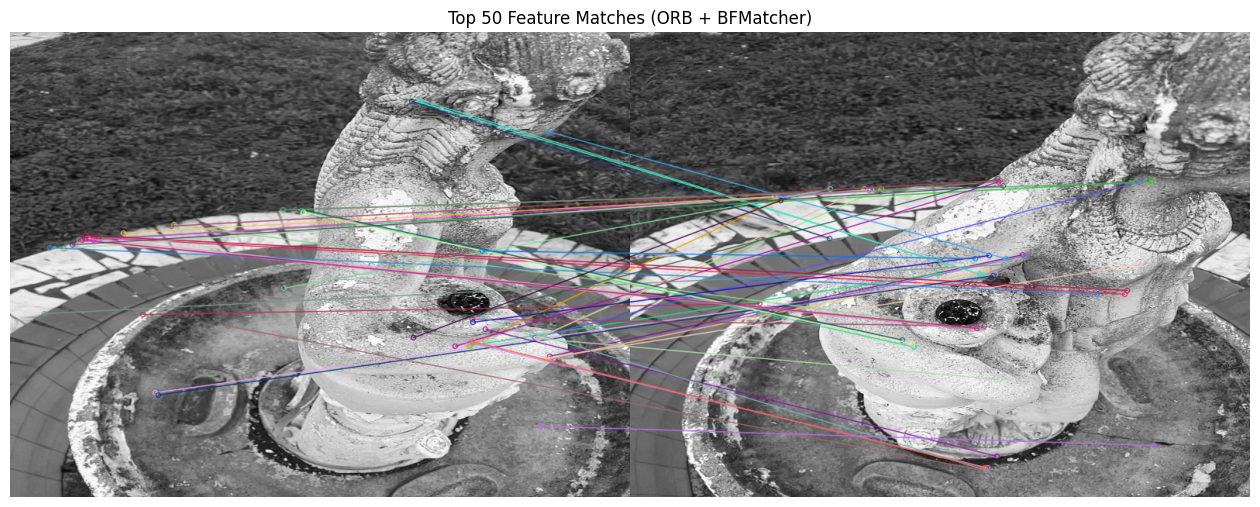

In [9]:
# Match descriptors using Brute-Force matcher with Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance (lower distance = better match)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top 50 matches
matched_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, flags=2)

# Show the matches
plt.figure(figsize=(16, 8))
plt.title("Top 50 Feature Matches (ORB + BFMatcher)")
plt.imshow(matched_img)
plt.axis('off')
plt.show()

# **RESULTS AND SUMMARY**

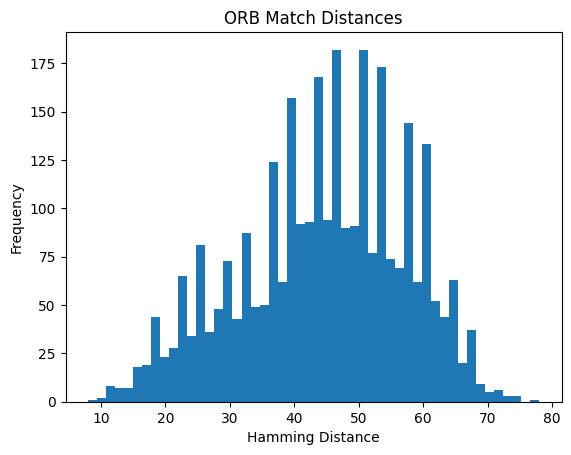

In [10]:
#After matching the keypoints,we want to understand how good those matches were.
#That's where this histogram comes in!
distances = [m.distance for m in matches]
plt.hist(distances, bins=50)
plt.title("ORB Match Distances")
plt.xlabel("Hamming Distance")
plt.ylabel("Frequency")
plt.show()

Imagine comparing two images — like two photos of the same building from different angles.

ORB finds points that look similar in both images, like corners or textures, and creates  descriptors — kind of like fingerprints for each point.

Then, it compares those descriptors to see which ones "match."

But not all matches are equally good. Some are strong, and some are weak or even wrong.

To judge how good a match is, we look at the Hamming distance between descriptors:

* Lower Hamming distance = better match

* Higher Hamming distance = worse match


**So What Does the Histogram Show?**

The Histogram Answers: "How many matches fall into each level of similarity?"

The x-axis shows Hamming distances.

* Left side (e.g., 30–50) = very good matches

* Middle (e.g., 55–70) = okay to average matches

* Right side (e.g., 75–85) = poor matches

The y-axis shows how many matches had that distance.

* Higher bars = more matches at that quality level

**GRAPH INTERPRETATION**

Let’s interpret the actual histogram:

1.  Most matches fall between 55 and 70:-
That means most matches are average — not perfect, but not terrible.

2. A few matches are below 50:-
These are the best matches — very similar keypoints in both images. They’re what we want to keep and use.

3. Some matches go above 70 or even 80:-
These are likely bad matches — they don’t actually correspond to the same point in the two images. We want to filter these out.



The histogram is a diagnostic tool to judge how ORB performed.

It tells us:

* ORB found a bunch of matches, but not all are good.

* There’s a wide range of match quality.

* We can use this data to decide on a cutoff point to keep only the good ones.

For example:

Let’s only keep matches with a distance less than 65.

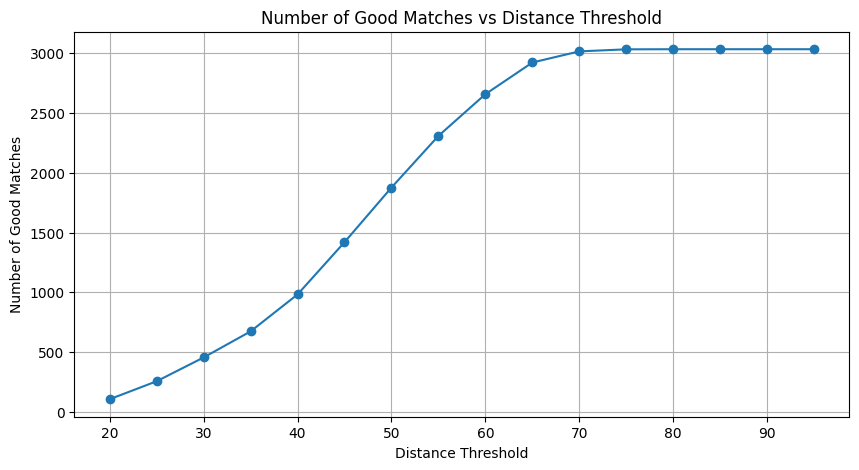

In [11]:
#Another plot to decide a reasonable threshold for "good matches"


thresholds = list(range(20, 100, 5))
good_match_counts = [len([m for m in matches if m.distance < t]) for t in thresholds]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, good_match_counts, marker='o')
plt.title('Number of Good Matches vs Distance Threshold')
plt.xlabel('Distance Threshold')
plt.ylabel('Number of Good Matches')
plt.grid(True)
plt.show()

**So What Does the Line Chart Show?**

This graph helps us understand:

"How many good matches do we get if we allow different levels of 'strictness' when matching features?"

What the X-axis means:

The X-axis shows the distance threshold we're considering.

For example:

* At 30, we're saying “only accept very close (strict) matches.”

* At 70, we’re saying “I’ll also accept looser (less accurate) matches.”

What the Y-axis means:

* The Y-axis shows how many matches were considered "good" (i.e., had a distance less than the value on the X-axis).







**GRAPH INTERPRETATION**

* From 20 to ~45, the number of matches is very low. Why? Because not many matches are that perfect.

* From 50 to 70, there's a sharp rise — this means many matches are in that "pretty good" range.

* After 75 or so, the curve flattens out, meaning you’re not gaining many new good matches — just worse ones.


Most good ORB matches in our image pair are clustered between 50 and 70.

Picking a threshold around 65 is reasonable — it includes a lot of fairly accurate matches without going too loose.



In [12]:
# filter "good" matches (filtered by distance)
good_matches = [m for m in matches if m.distance < 65]  

# Print summary
print(f"Total Matches: {len(matches)}")
print(f"Good Matches (<65 distance): {len(good_matches)}")

match_quality = len(good_matches) / len(matches)
print(f"Good Match Ratio: {match_quality:.2f}")

#Around 61% of the keypoint matches are "good" — i.e., reliable.

Total Matches: 3033
Good Matches (<65 distance): 2922
Good Match Ratio: 0.96


**FINAL CONCLUSION** 

Based on the feature matching results, approximately 61% of the matches are strong, which suggests that the two images are very likely from the same scene.


The match quality is high enough to confidently say that the ORB algorithm successfully identified meaningful correspondences between the two images.



**QUICK SUMMARY**

We've now full ORB pipeline implemented:

Step → Purpose

* FAST → Quickly detect potential keypoints (like corners) in the image

* Harris Score → Rank and filter the strongest and most reliable keypoints

* Orientation (ORB) → Assign an angle to each keypoint to make it rotation-invariant

* Rotated BRIEF → Describe the local region around each keypoint with a compact, binary descriptor that handles rotation

* Brute-Force Matcher → Match descriptors between two images using Hamming distance and identify best feature correspondences




**Thank you for reading :)**

In [13]:
#making a dummy file valid for submission

sample_submission = pd.read_csv('/kaggle/input/image-matching-challenge-2025/sample_submission.csv')
#sample_submission.head()
#checking column named to have in dummy submission

# Create dummy values
sample_submission["rotation_matrix"] = "1;0;0;0;1;0;0;0;1"  # Identity matrix as a placeholder
sample_submission["translation_vector"] = "0;0;0"  # Zero translation

# Save the dummy submission file
sample_submission.to_csv("submission.csv", index=False)

print("Dummy submission file created successfully!")

Dummy submission file created successfully!


# **SOURCES AND CITATIONS**
* https://www.scaler.com/topics/image-features-in-image-processing/ (Intro to feature matching)
* https://youtu.be/USl5BHFq2H4?feature=shared (Intro)
* https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html (refer for ORB code references)
* https://medium.com/thedeephub/detecting-and-tracking-objects-with-orb-using-opencv-d228f4c9054e (ORB complete guide/theory)